In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import random
import cv2
from sklearn.metrics import classification_report

from finetuning_functions import training_plots, dice_coefficient, Unet, plot_validation_masks
from pretraining_functions import unet_mod, resnet50_encoder, BarlowTwins

2023-11-01 14:19:41.144229: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 14:19:41.181809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 14:19:41.181835: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 14:19:41.181868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 14:19:41.189597: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_path = os.path.join("..", "..", "..", "media", "FS2","models")

# Data Loading

In [3]:
labeled_data_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_masks")

In [4]:
masked_images = [0 for i in range(130)]
smoke_masks = [0 for i in range(130)] 
cloud_masks =[0 for i in range(130)]
image_nos = []
for subdir, dirs, files in os.walk(labeled_data_dir):
    for file in files:
        file_path = os.path.join(labeled_data_dir, file)
        mask = np.load(os.path.join(labeled_data_dir, file))
        image_no = int(file.split("-")[1])-1
        image_nos.append(image_no)
        if "Smoke" in file_path and not "cloud" in file:
            smoke_masks[image_no] = mask
        if "cloud" in file:
            cloud_masks[image_no] = mask

In [5]:
for i in range(len(smoke_masks)):
    if np.shape(cloud_masks[i]) == ():
        blank_img = np.zeros(smoke_masks[i].shape,dtype=np.uint8)
        cloud_masks[i] = blank_img
    if np.shape(smoke_masks[i]) == ():
        blank_img = np.zeros(cloud_masks[i].shape,dtype=np.uint8)
        smoke_masks[i] = blank_img

In [6]:
(len(smoke_masks), len(cloud_masks))

(130, 130)

In [7]:
def combine_masks(smoke_masks, cloud_masks):
    masks = [0 for i in range(len(smoke_masks))]
    for i in range(len(smoke_masks)):
        smoke = smoke_masks[i]
        smoke = np.where(smoke==0, smoke, 1)
        temp = cloud_masks[i]
        temp = np.where(cloud_masks[i]!=255, cloud_masks[i], 2) #changing color to grey
        temp = np.where(cloud_masks[i]==0, temp, 2)
        full_mask = temp + smoke
        full_mask = np.where(full_mask!=3, full_mask, 1 )
        masks[i] = full_mask
    return masks

In [8]:
masked_images = combine_masks(smoke_masks, cloud_masks)

In [9]:
import re
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [10]:
originals = []
original_image_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_images")
for subdir, dirs, files in os.walk(original_image_dir):
    for file in sorted(files, key=numericalSort):
        image = Image.open(os.path.join(original_image_dir, file)).convert('RGB')
        np_original = np.asarray(image)
        originals.append(np_original)
originals = originals[:130]
len(originals)

130

In [11]:
random.seed(42)
inds = random.sample([i for i in range(130)], 25)

In [12]:
class DataLoader:
    def __init__(self, masks, originals, target_shape=(256, 256)):
        self.masks = masks
        self.originals = originals
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.target_shape = target_shape
        
    @tf.function
    def parse_images(self, ind):
        mask = cv2.resize(np.expand_dims(self.masks[ind], axis=-1), self.target_shape)
        image = cv2.resize(self.originals[ind], self.target_shape)
        return image, mask
    
    @tf.function
    def data_generator(self, batch_size=4):
        random.seed(0)
        inds = random.sample([i for i in range(len(self.originals))], batch_size)
        inputs = [self.parse_images(ind)[0] for ind in inds]
        targets = [self.parse_images(ind)[1] for ind in inds]
        return inputs, targets

    def data_processor(self):
        inputs = [ cv2.resize(self.originals[ind], self.target_shape) for ind in range(len(self.originals))]
        return inputs


In [13]:
input_size = (512,512)
batch_size = 4
val_batch_size = 4

In [14]:
test_dataset = DataLoader(masked_images, originals, target_shape=input_size)
inputs, targets = test_dataset.data_generator(130)

2023-11-01 14:19:44.577872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14757 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d5:00.0, compute capability: 7.5


In [15]:
val_input = [inputs[ind] for ind in inds]
val_target = [targets[ind] for ind in inds]
val = tf.data.Dataset.from_tensor_slices((val_input, val_target))

# Data Augmentation

In [16]:
inputs = [inputs[ind] for ind in range(130) if ind not in inds]
targets = [targets[ind] for ind in range(130) if ind not in inds]

In [17]:
# augmentation - flip hz, flip vt, hz+vt flip, rotation 90, 180, 270

augmented_inputs = []
augmented_labels = []

# flip hz
hz_inputs = [np.flip(img, axis=1) for img in inputs]
hz_labels =  [np.flip(img, axis=1) for img in targets]
augmented_inputs = hz_inputs
augmented_labels = hz_labels

# flip vt
vt_inputs = [np.flip(img, axis=0) for img in inputs]
vt_labels =  [np.flip(img, axis=0) for img in targets]
augmented_inputs = np.append(vt_inputs, augmented_inputs, axis=0)
augmented_labels = np.append(vt_labels, augmented_labels, axis=0)

# hz+vt flip
hzvt_inputs = [np.flip(img, axis=0) for img in hz_inputs]
hzvt_labels =  [np.flip(img, axis=0) for img in hz_labels]
augmented_inputs = np.append(hzvt_inputs, augmented_inputs, axis=0)
augmented_labels = np.append(hzvt_labels, augmented_labels, axis=0)

# add to originals
augmented_inputs = np.append(inputs, augmented_inputs, axis=0)
augmented_labels = np.append(targets, augmented_labels, axis=0)

# rotations 
rot90_inputs = [np.flip(img, axis=0) for img in augmented_inputs]
rot90_labels =  [np.flip(img, axis=0) for img in augmented_labels]
rot180_inputs = [np.flip(img, axis=0) for img in rot90_inputs]
rot180_labels =  [np.flip(img, axis=0) for img in rot90_labels]
rot270_inputs = [np.flip(img, axis=0) for img in rot180_inputs]
rot270_labels =  [np.flip(img, axis=0) for img in rot180_labels]

rotation_inputs = rot90_inputs + rot180_inputs + rot270_inputs
rotation_labels = rot90_labels + rot180_labels + rot270_labels 

# add rotations
augmented_inputs = np.append(rotation_inputs, augmented_inputs, axis=0)
augmented_labels = np.append(rotation_labels, augmented_labels, axis=0)


In [18]:
train = tf.data.Dataset.from_tensor_slices((inputs, targets))
train_augmented = tf.data.Dataset.from_tensor_slices((augmented_inputs, augmented_labels))

In [19]:
train_batches = train_augmented.batch(batch_size)
val_batches = val.batch(val_batch_size)

# Training Set up

In [20]:
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/smoke_segmentation_256.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=10e-8,
)

In [21]:
# training parameters
epochs =500
lr = 0.00001

# resnet

## Transfer learning: Backbone frozen

In [22]:
input_shape = input_size

In [23]:
optimizer = tf.keras.optimizers.SGD()
input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1], 3))
encoder = resnet50_encoder(input)
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)
barlow_twins.encoder.load_weights(os.path.join(model_path, "barlow_twins_resnet"))

2023-11-01 14:19:53.433725: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../../../media/FS2/models/barlow_twins_resnet: FAILED_PRECONDITION: ../../../media/FS2/models/barlow_twins_resnet; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [24]:
backbone = tf.keras.Model( barlow_twins.encoder.input, barlow_twins.encoder.layers[-2].output)
backbone.trainable = False

In [25]:
backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [26]:
s1 = backbone.get_layer(index=0).output           ## (512 x 512)
s2 = backbone.get_layer("conv1_relu").output        ## (256 x 256)
s3 = backbone.get_layer("conv2_block3_out").output  ## (128 x 128)
s4 = backbone.get_layer("conv3_block4_out").output  ## (64 x 64)
skip_layers = [s1, s2, s3, s4]

BT_unet_T = unet_mod(backbone, skip_layers, input, num_filters=16, kernel=3, dropout=0.1, batch_norm=True, train_encoder=True)
BT_unet_T.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [27]:
BT_unet_T.compile(loss="sparse_categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                metrics=["accuracy", 
                        tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
                )

In [28]:
history = BT_unet_T.fit(
    train_batches,
    validation_data=val_batches,
    batch_size=batch_size,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Epoch 1/500


2023-11-01 14:19:59.449035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-01 14:20:00.268787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-01 14:20:07.453243: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5fd25500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 14:20:07.453285: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-01 14:20:07.463713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-01 14:20:07.612299: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster us

420/420 [==============================] - ETA: 0s - loss: 0.9515 - accuracy: 0.6099 - mean_io_u: 0.3948WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


/home/sandrade/miniconda3/envs/odin/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


420/420 [==============================] - 322s 704ms/step - loss: 0.9515 - accuracy: 0.6099 - mean_io_u: 0.3948 - val_loss: 0.4249 - val_accuracy: 0.8493 - val_mean_io_u: 0.6845 - lr: 1.0000e-05
Epoch 2/500
420/420 [==============================] - 293s 697ms/step - loss: 0.5320 - accuracy: 0.8215 - mean_io_u: 0.6346 - val_loss: 0.4272 - val_accuracy: 0.8508 - val_mean_io_u: 0.6903 - lr: 1.0000e-05
Epoch 3/500
420/420 [==============================] - 292s 696ms/step - loss: 0.3797 - accuracy: 0.8844 - mean_io_u: 0.7461 - val_loss: 0.4607 - val_accuracy: 0.8416 - val_mean_io_u: 0.6695 - lr: 1.0000e-05
Epoch 4/500
420/420 [==============================] - 293s 697ms/step - loss: 0.3062 - accuracy: 0.9092 - mean_io_u: 0.7955 - val_loss: 0.5041 - val_accuracy: 0.8272 - val_mean_io_u: 0.6393 - lr: 1.0000e-05
Epoch 5/500
420/420 [==============================] - 293s 699ms/step - loss: 0.2687 - accuracy: 0.9192 - mean_io_u: 0.8169 - val_loss: 0.4196 - val_accuracy: 0.8628 - val_mean_io

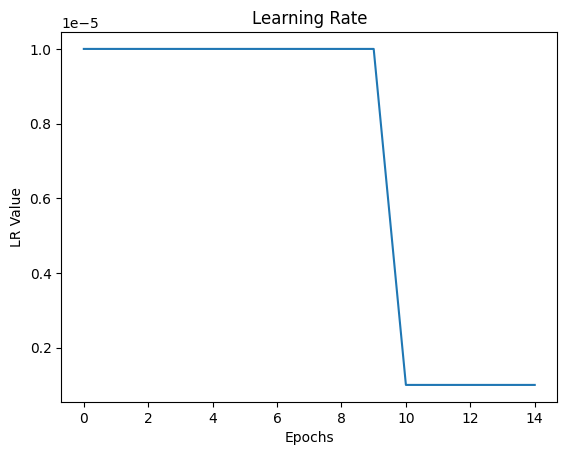

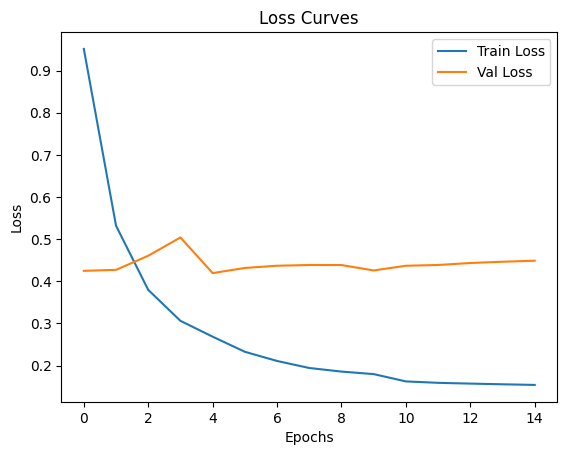

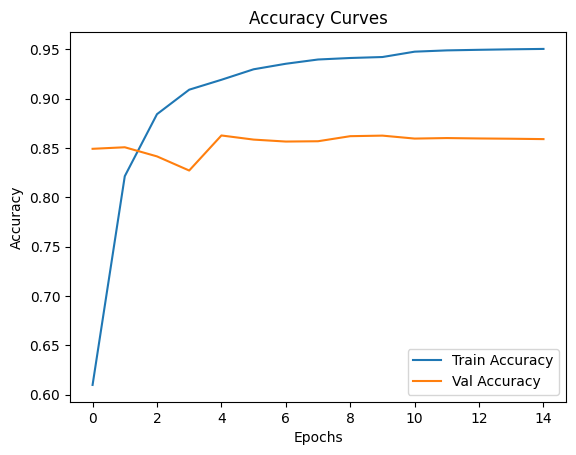

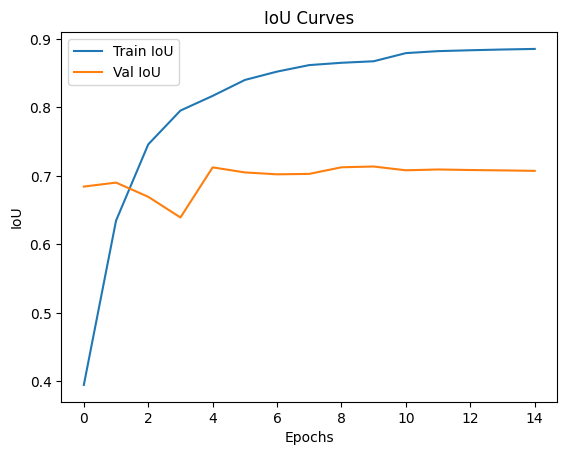

In [29]:
training_plots(history)

## Fine-tuning: Backbone trainable

In [30]:
optimizer = tf.keras.optimizers.SGD()
input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1], 3))
encoder = resnet50_encoder(input)
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)
barlow_twins.encoder.load_weights(os.path.join(model_path, "barlow_twins_resnet"))

2023-11-01 15:33:35.996633: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../../../media/FS2/models/barlow_twins_resnet: FAILED_PRECONDITION: ../../../media/FS2/models/barlow_twins_resnet; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [31]:
backbone = tf.keras.Model( barlow_twins.encoder.input, barlow_twins.encoder.layers[-2].output)

In [32]:
backbone.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [33]:
s1 = backbone.get_layer(index=0).output           ## (512 x 512)
s2 = backbone.get_layer("conv1_relu").output        ## (256 x 256)
s3 = backbone.get_layer("conv2_block3_out").output  ## (128 x 128)
s4 = backbone.get_layer("conv3_block4_out").output  ## (64 x 64)
skip_layers = [s1, s2, s3, s4]

BT_unet_FT = unet_mod(backbone, skip_layers, input, num_filters=16, kernel=3, dropout=0.1, batch_norm=True, train_encoder=True)
BT_unet_FT.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [34]:
BT_unet_FT.compile(loss="sparse_categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                metrics=["accuracy", 
                        tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
                )

In [35]:
history = BT_unet_FT.fit(
    train_batches,
    validation_data=val_batches,
    batch_size=batch_size,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Epoch 1/500


2023-11-01 15:33:47.260039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 33/420 [=>............................] - ETA: 5:29 - loss: 1.0346 - accuracy: 0.5264 - mean_io_u_1: 0.2778

420/420 [==============================] - 391s 865ms/step - loss: 0.7174 - accuracy: 0.6981 - mean_io_u_1: 0.4431 - val_loss: 0.4515 - val_accuracy: 0.8205 - val_mean_io_u_1: 0.6269 - lr: 1.0000e-05
Epoch 2/500
420/420 [==============================] - 363s 863ms/step - loss: 0.4687 - accuracy: 0.8326 - mean_io_u_1: 0.6406 - val_loss: 0.4253 - val_accuracy: 0.8372 - val_mean_io_u_1: 0.6639 - lr: 1.0000e-05
Epoch 3/500
420/420 [==============================] - 362s 863ms/step - loss: 0.3442 - accuracy: 0.8878 - mean_io_u_1: 0.7508 - val_loss: 0.4253 - val_accuracy: 0.8418 - val_mean_io_u_1: 0.6727 - lr: 1.0000e-05
Epoch 4/500
420/420 [==============================] - 362s 863ms/step - loss: 0.2708 - accuracy: 0.9156 - mean_io_u_1: 0.8096 - val_loss: 0.4427 - val_accuracy: 0.8432 - val_mean_io_u_1: 0.6754 - lr: 1.0000e-05
Epoch 5/500
420/420 [==============================] - 362s 863ms/step - loss: 0.2315 - accuracy: 0.9283 - mean_io_u_1: 0.8365 - val_loss: 0.4823 - val_accuracy: 0.

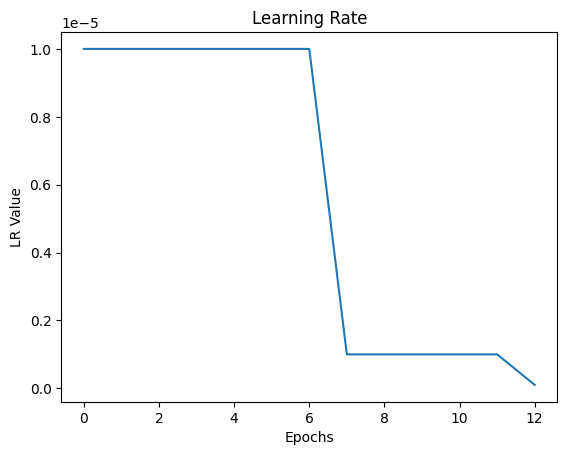

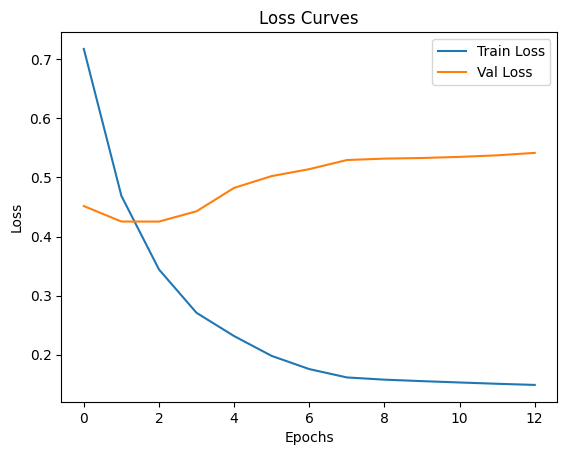

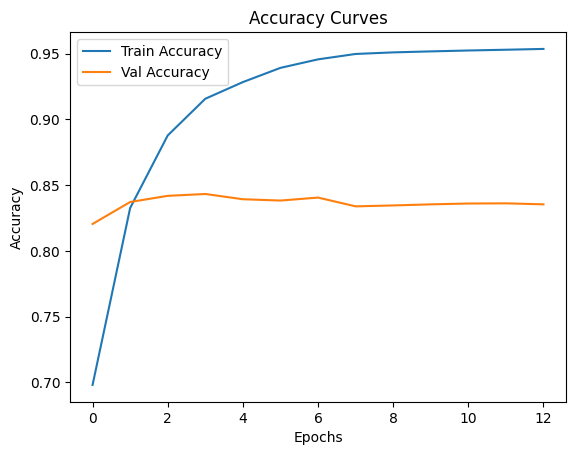

KeyError: 'mean_io_u'

In [36]:
training_plots(history)

# Evaluation

Regular vs Augmented

In [37]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [38]:
train_batches = train.batch(batch_size)

In [39]:
train_images, train_labels = tuple(zip(*train))
preds = BT_unet_T.predict(train_batches)
print(classification_report(np.array(train_labels).flatten(), np.array(tf.argmax(preds, axis=-1)).flatten()))

27/27 [==============================] - 7s 213ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93  16930564
           1       0.81      0.80      0.80   5151382
           2       0.95      0.84      0.89   5443174

    accuracy                           0.90  27525120
   macro avg       0.89      0.86      0.88  27525120
weighted avg       0.90      0.90      0.90  27525120



In [40]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(train_labels, tf.argmax(preds, axis=-1))
regular_iou = m.result().numpy()

In [41]:
images, labels = tuple(zip(*val))
preds = BT_unet_T.predict(val_batches)
pred_mask = tf.argmax(preds, axis=-1) 

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 1s 213ms/step


In [42]:
regular_metrics = classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten(), output_dict=True)

In [43]:
print(classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten()))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92   3642002
           1       0.83      0.66      0.74   1405225
           2       0.89      0.77      0.83   1506373

    accuracy                           0.86   6553600
   macro avg       0.86      0.80      0.83   6553600
weighted avg       0.86      0.86      0.86   6553600



In [44]:
m.reset_state()
m.update_state(labels, pred_mask)
m.result().numpy()
regular_iou = m.result().numpy()

In [45]:
#plot_validation_masks(images, pred_mask, labels)

In [46]:
train_images, train_labels = tuple(zip(*train))
preds = BT_unet_FT.predict(train_batches)
print(classification_report(np.array(train_labels).flatten(), np.array(tf.argmax(preds, axis=-1)).flatten()))

27/27 [==============================] - 7s 221ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.94  16930564
           1       0.86      0.86      0.86   5151382
           2       0.95      0.77      0.85   5443174

    accuracy                           0.91  27525120
   macro avg       0.91      0.87      0.88  27525120
weighted avg       0.91      0.91      0.91  27525120



In [47]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(train_labels, tf.argmax(preds, axis=-1))
m.result().numpy()

0.7951577

In [48]:
images, labels = tuple(zip(*val))
preds = BT_unet_FT.predict(val_batches)
pred_mask = tf.argmax(preds, axis=-1) 

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 1s 220ms/step


In [49]:
print(classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten()))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91   3642002
           1       0.77      0.64      0.70   1405225
           2       0.90      0.69      0.78   1506373

    accuracy                           0.84   6553600
   macro avg       0.84      0.77      0.80   6553600
weighted avg       0.84      0.84      0.83   6553600



In [50]:
m.reset_state()
m.update_state(labels, pred_mask)
FT_iou = m.result().numpy()

In [51]:
#plot_validation_masks(images, preds, labels)

# Comparison

In [52]:
FT_metrics = classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten(), output_dict=True)

In [53]:
FT = [FT_metrics["accuracy"],FT_metrics["macro avg"]["precision"], FT_metrics["macro avg"]["recall"], FT_metrics["macro avg"]["f1-score"], FT_iou]
regular = [regular_metrics["accuracy"],regular_metrics["macro avg"]["precision"], regular_metrics["macro avg"]["recall"], regular_metrics["macro avg"]["f1-score"], regular_iou]
metrics = ["accuracy", "precision", "recall", "f1-score", "mean IoU"]

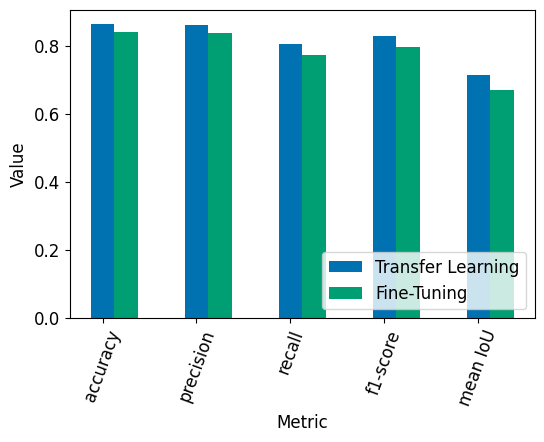

In [54]:
# barplot with one bar for each
# acccuracy, precision, recall, f1, mean_iou
plt.style.use('seaborn-v0_8-colorblind') 
X_axis = np.arange(len(metrics))
num_bars = 2
width = 1/(num_bars+2)
i=1
plt.figure(figsize=(6,4))
plt.bar(X_axis+(width*1), regular, width, label="Transfer Learning")
plt.bar(X_axis+(width*2), FT, width, label="Fine-Tuning")
plt.xticks(X_axis+(width*np.ceil(num_bars/2)), metrics, rotation=70)
plt.tick_params(labelsize=12)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.show()

In [55]:
BT_unet_FT.save(os.path.join(model_path, "BT_resnet_unet_FT"))
BT_unet_T.save(os.path.join(model_path, "BT_resnet_unet_T"))

INFO:tensorflow:Assets written to: ../../../media/FS2/models/BT_resnet_unet_FT/assets


INFO:tensorflow:Assets written to: ../../../media/FS2/models/BT_resnet_unet_FT/assets


INFO:tensorflow:Assets written to: ../../../media/FS2/models/BT_resnet_unet_T/assets


INFO:tensorflow:Assets written to: ../../../media/FS2/models/BT_resnet_unet_T/assets
